In [1]:
!pip install einops

In [ ]:
#importing libraries that will be used 
import torch 
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler #for validation test
from einops.layers.torch import Rearrange
from sklearn import preprocessing

In [ ]:
#convert images to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5),)])
transform


Compose(
    ToTensor()
    Normalize(mean=0.5, std=0.5)
)

In [ ]:
#load data into training and test 
train_set = datasets.FashionMNIST('~/ .pytorch/F_MNIST_data', download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST('~/ .pytorch/F_MNIST_data', download=True, train=False, transform=transform)

In [ ]:
#preparing for validation test
indices = list(range(len(train_set)))
np.random.shuffle(indices)

#to assign 20% data from train_test to validation_test
split = int(np.floor(0.2*len(train_set)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data loader
train_loader = torch.utils.data.DataLoader(train_set, sampler=train_sample, batch_size=64)
validation_loader = torch.utils.data.DataLoader(train_set, sampler=valid_sample, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle = True)

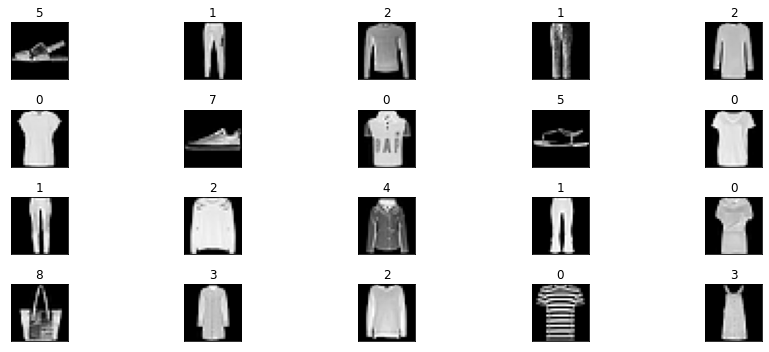

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

data_iter = iter(train_loader)
print(data_iter)
images, labels = data_iter.next()

fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')

  ax.set_title(labels[idx].item())
  fig.tight_layout()

In [ ]:
train_loader

In [ ]:
from re import X
class NN_Model(nn.Sequential):
  #patch_img=[]
  def __init__(self,input_size,patch_size, img_channel):
    super(NN_Model,self).__init__()
    self.input_size = input_size
    self.patch_size = patch_size
    self.img_channel = img_channel
    num_hidden_1 = 512
    num_hidden_2 = 256
    num_hidden_3 = 128
    num_hidden_4 = 64
    output = 10
    #patch_img = []
    
    assert (input_size[0] % patch_size[0])==0,'H must be divisible by patch size'
    assert (input_size[1] % patch_size[1])==0,'W must be divisible by patch size'
    num_patches = int(input_size[0]/patch_size[0]*input_size[1]/patch_size[1])
    patch_dim = img_channel * patch_size[0] * patch_size[1]
    
    self.to_patch_embedding = nn.Sequential(
                      Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size[0], p2 = patch_size[1]),
                      nn.Linear(patch_dim, patch_dim))
      #print(self.to_patch_embedding)
    img = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size[0], p2 = patch_size[1])
    #print(img)
    self.Linear1 = nn.Linear(patch_dim,num_hidden_1)
    self.Linear2 = nn.Linear(num_hidden_1,num_hidden_2)
    self.Linear3 = nn.Linear(num_patches,num_hidden_3)
    self.Linear4 = nn.Linear(num_hidden_3,num_hidden_4)
    #self.classifier = nn.Linear(num_hidden_4,output)
    #self.classifier = F.log_softmax(num_hidden_4,output)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.1)
    
  def forward(self,x):
    x = self.to_patch_embedding(x)
    x = self.Linear1(x)
    x = self.dropout(self.relu(x))
    x = self.Linear2(x)
    x = self.dropout(self.relu(x))
    x = x.transpose(1,2)
    x = self.Linear3(x)
    x =self.dropout(self.relu(x))
    x = self.Linear4(x)
    x =self.dropout(self.relu(x))     
    x = torch.mean(x,dim=1)
    out = F.log_softmax(x, dim=1)
    return out


In [ ]:
input_size = (28,28)
patch_size = (7,7)
img_channel= 1
model = NN_Model(input_size,patch_size, img_channel)
#defining the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
#optimizer = optim.Adam(model.parameters(), lr=0.05)

valid_loss_min = np.Inf #using this high value to make sure the update the weight first time
epochs = 45
steps = 0
model.train() #prep model for training
train_losses, valid_losses = [],[]
for e in range(epochs):
  running_loss =0 
  valid_loss = 0
   # train the model #
  for images, labels in train_loader:

     optimizer.zero_grad()
     log_ps = model(images)
     #print(log_ps)
     loss = criterion(log_ps, labels)
     loss.backward()
     optimizer.step()
     running_loss += loss.item()*images.size(0)
     #print(running_loss)
  
  for images, labels in validation_loader:
     log_ps = model(images)
     loss = criterion(log_ps, labels)
     valid_loss += loss.item()*images.size(0)

  running_loss = running_loss/len(train_loader.sampler)
  valid_loss =  valid_loss/len(validation_loader.sampler)
  train_losses.append(running_loss)
  valid_losses.append(valid_loss)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1,
        running_loss,
        valid_loss
    ))
  if valid_loss <= valid_loss_min:
      print('validation loss decreased({:.6f} -->{:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
      torch.save(model.state_dict(), 'model.pt')
      valid_loss_min = valid_loss

  




Epoch: 1 	Training Loss: 3.349061 	Validation Loss: 2.932725
validation loss decreased(inf -->2.932725). Saving Model ...
Epoch: 2 	Training Loss: 1.931903 	Validation Loss: 1.053094
validation loss decreased(2.932725 -->1.053094). Saving Model ...
Epoch: 3 	Training Loss: 0.860947 	Validation Loss: 0.877354
validation loss decreased(1.053094 -->0.877354). Saving Model ...
Epoch: 4 	Training Loss: 0.759980 	Validation Loss: 0.767367
validation loss decreased(0.877354 -->0.767367). Saving Model ...
Epoch: 5 	Training Loss: 0.728226 	Validation Loss: 0.748798
validation loss decreased(0.767367 -->0.748798). Saving Model ...
Epoch: 6 	Training Loss: 0.702647 	Validation Loss: 0.693225
validation loss decreased(0.748798 -->0.693225). Saving Model ...
Epoch: 7 	Training Loss: 0.685687 	Validation Loss: 0.695810
Epoch: 8 	Training Loss: 0.671173 	Validation Loss: 0.724007
Epoch: 9 	Training Loss: 0.657967 	Validation Loss: 0.656174
validation loss decreased(0.693225 -->0.656174). Saving Mode

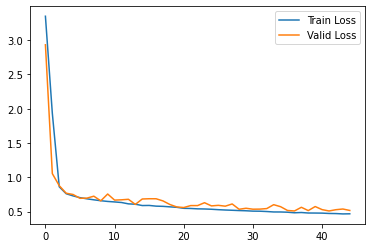

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()

In [ ]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
#track the test loss
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


model.eval()
for images, labels in test_loader:
  #forword pass 
  output = model(images)
  #calculate the loss
  loss = criterion(output, labels)
  #update the test loss
  test_loss += loss.item()*images.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  #compare predictions to the true labes
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
  #calculate test accuracy for each object class
  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] +=1

#calcaulate and prınt test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%
          (str(i), 100 * class_correct[i]/class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A(no training examples)' % classes[i])

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))



Test Loss: 0.558673

Test Accuracy of     0: 77% (778/1000)
Test Accuracy of     1: 96% (969/1000)
Test Accuracy of     2: 70% (707/1000)
Test Accuracy of     3: 76% (764/1000)
Test Accuracy of     4: 78% (786/1000)
Test Accuracy of     5: 81% (815/1000)
Test Accuracy of     6: 50% (509/1000)
Test Accuracy of     7: 96% (963/1000)
Test Accuracy of     8: 92% (923/1000)
Test Accuracy of     9: 85% (854/1000)

Test Accuracy (Overall): 80% (8068/10000)


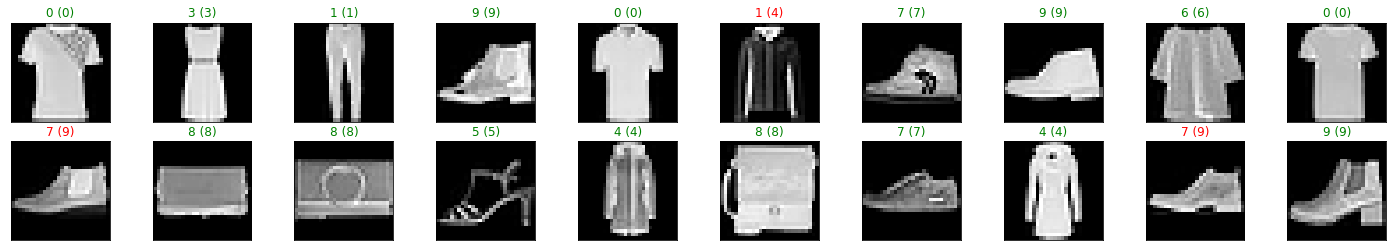

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))